==> Loading data
==> Loaded data in: 0 m : 12 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



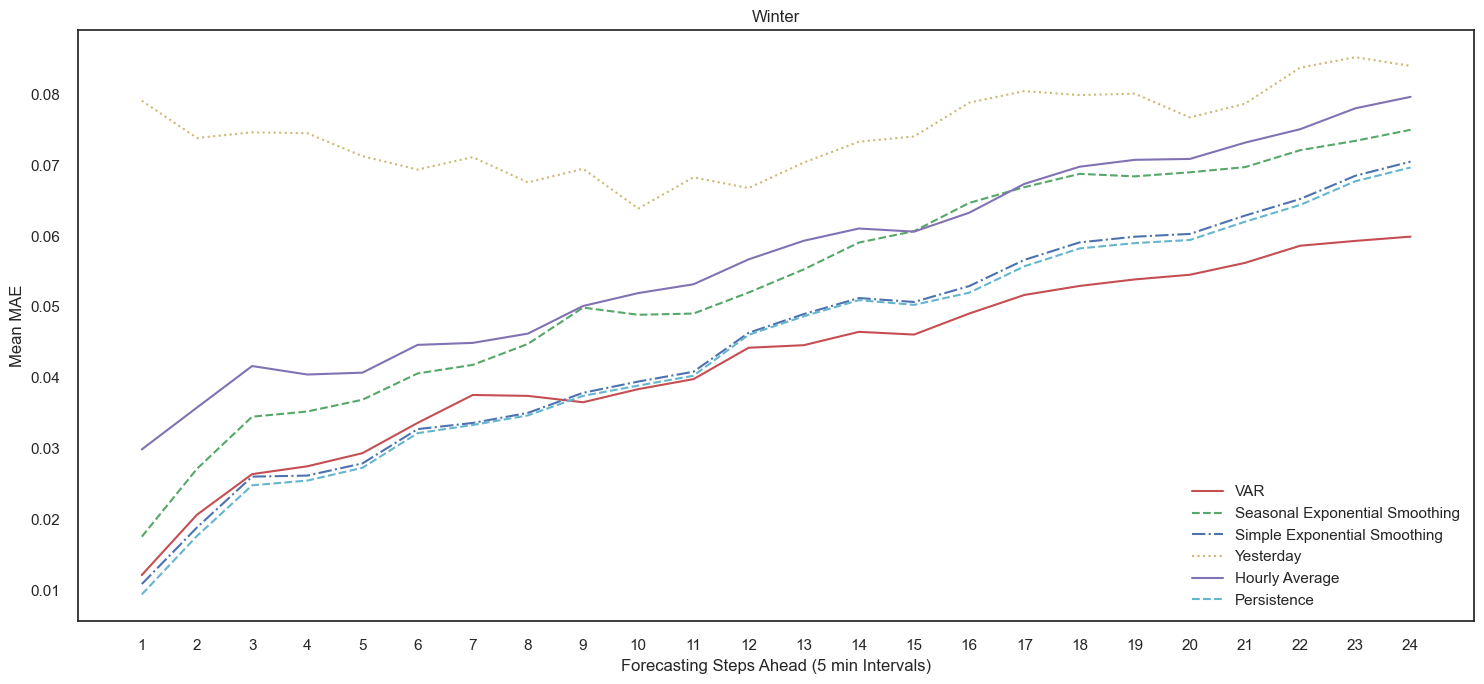

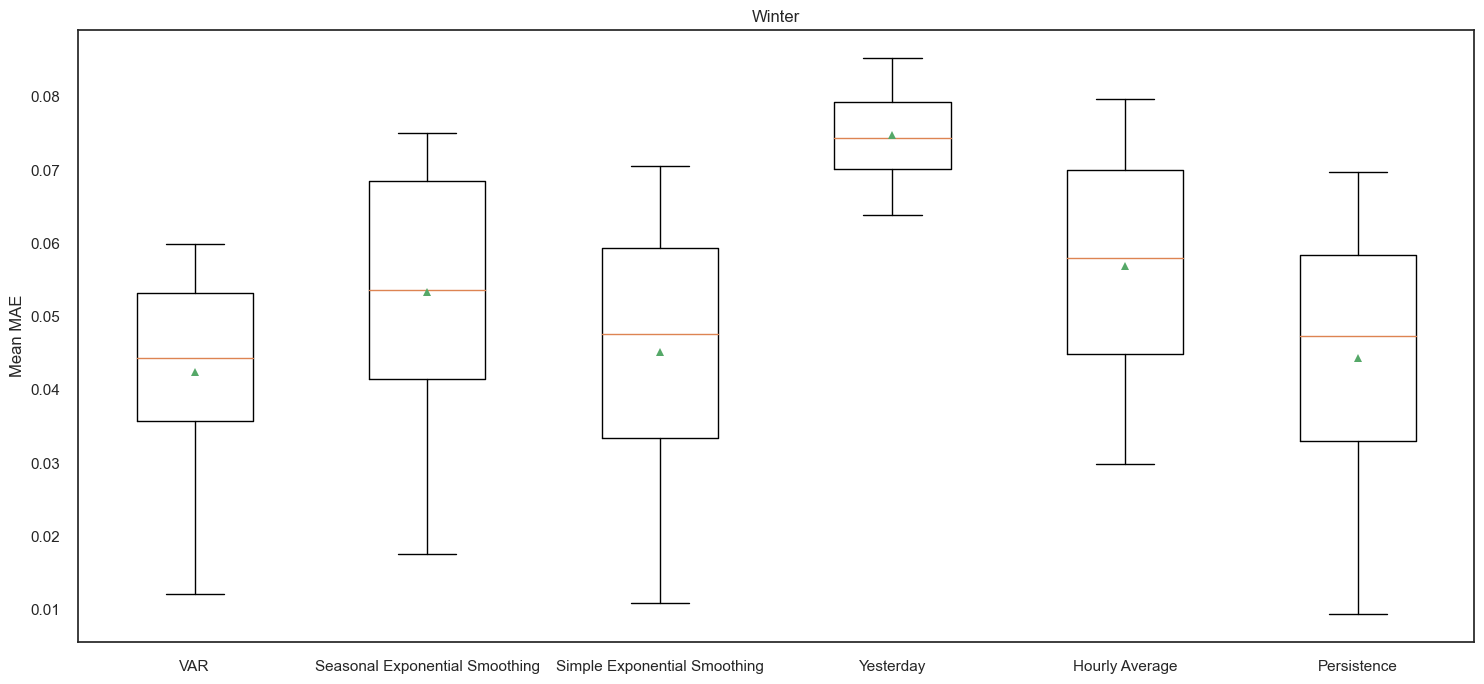

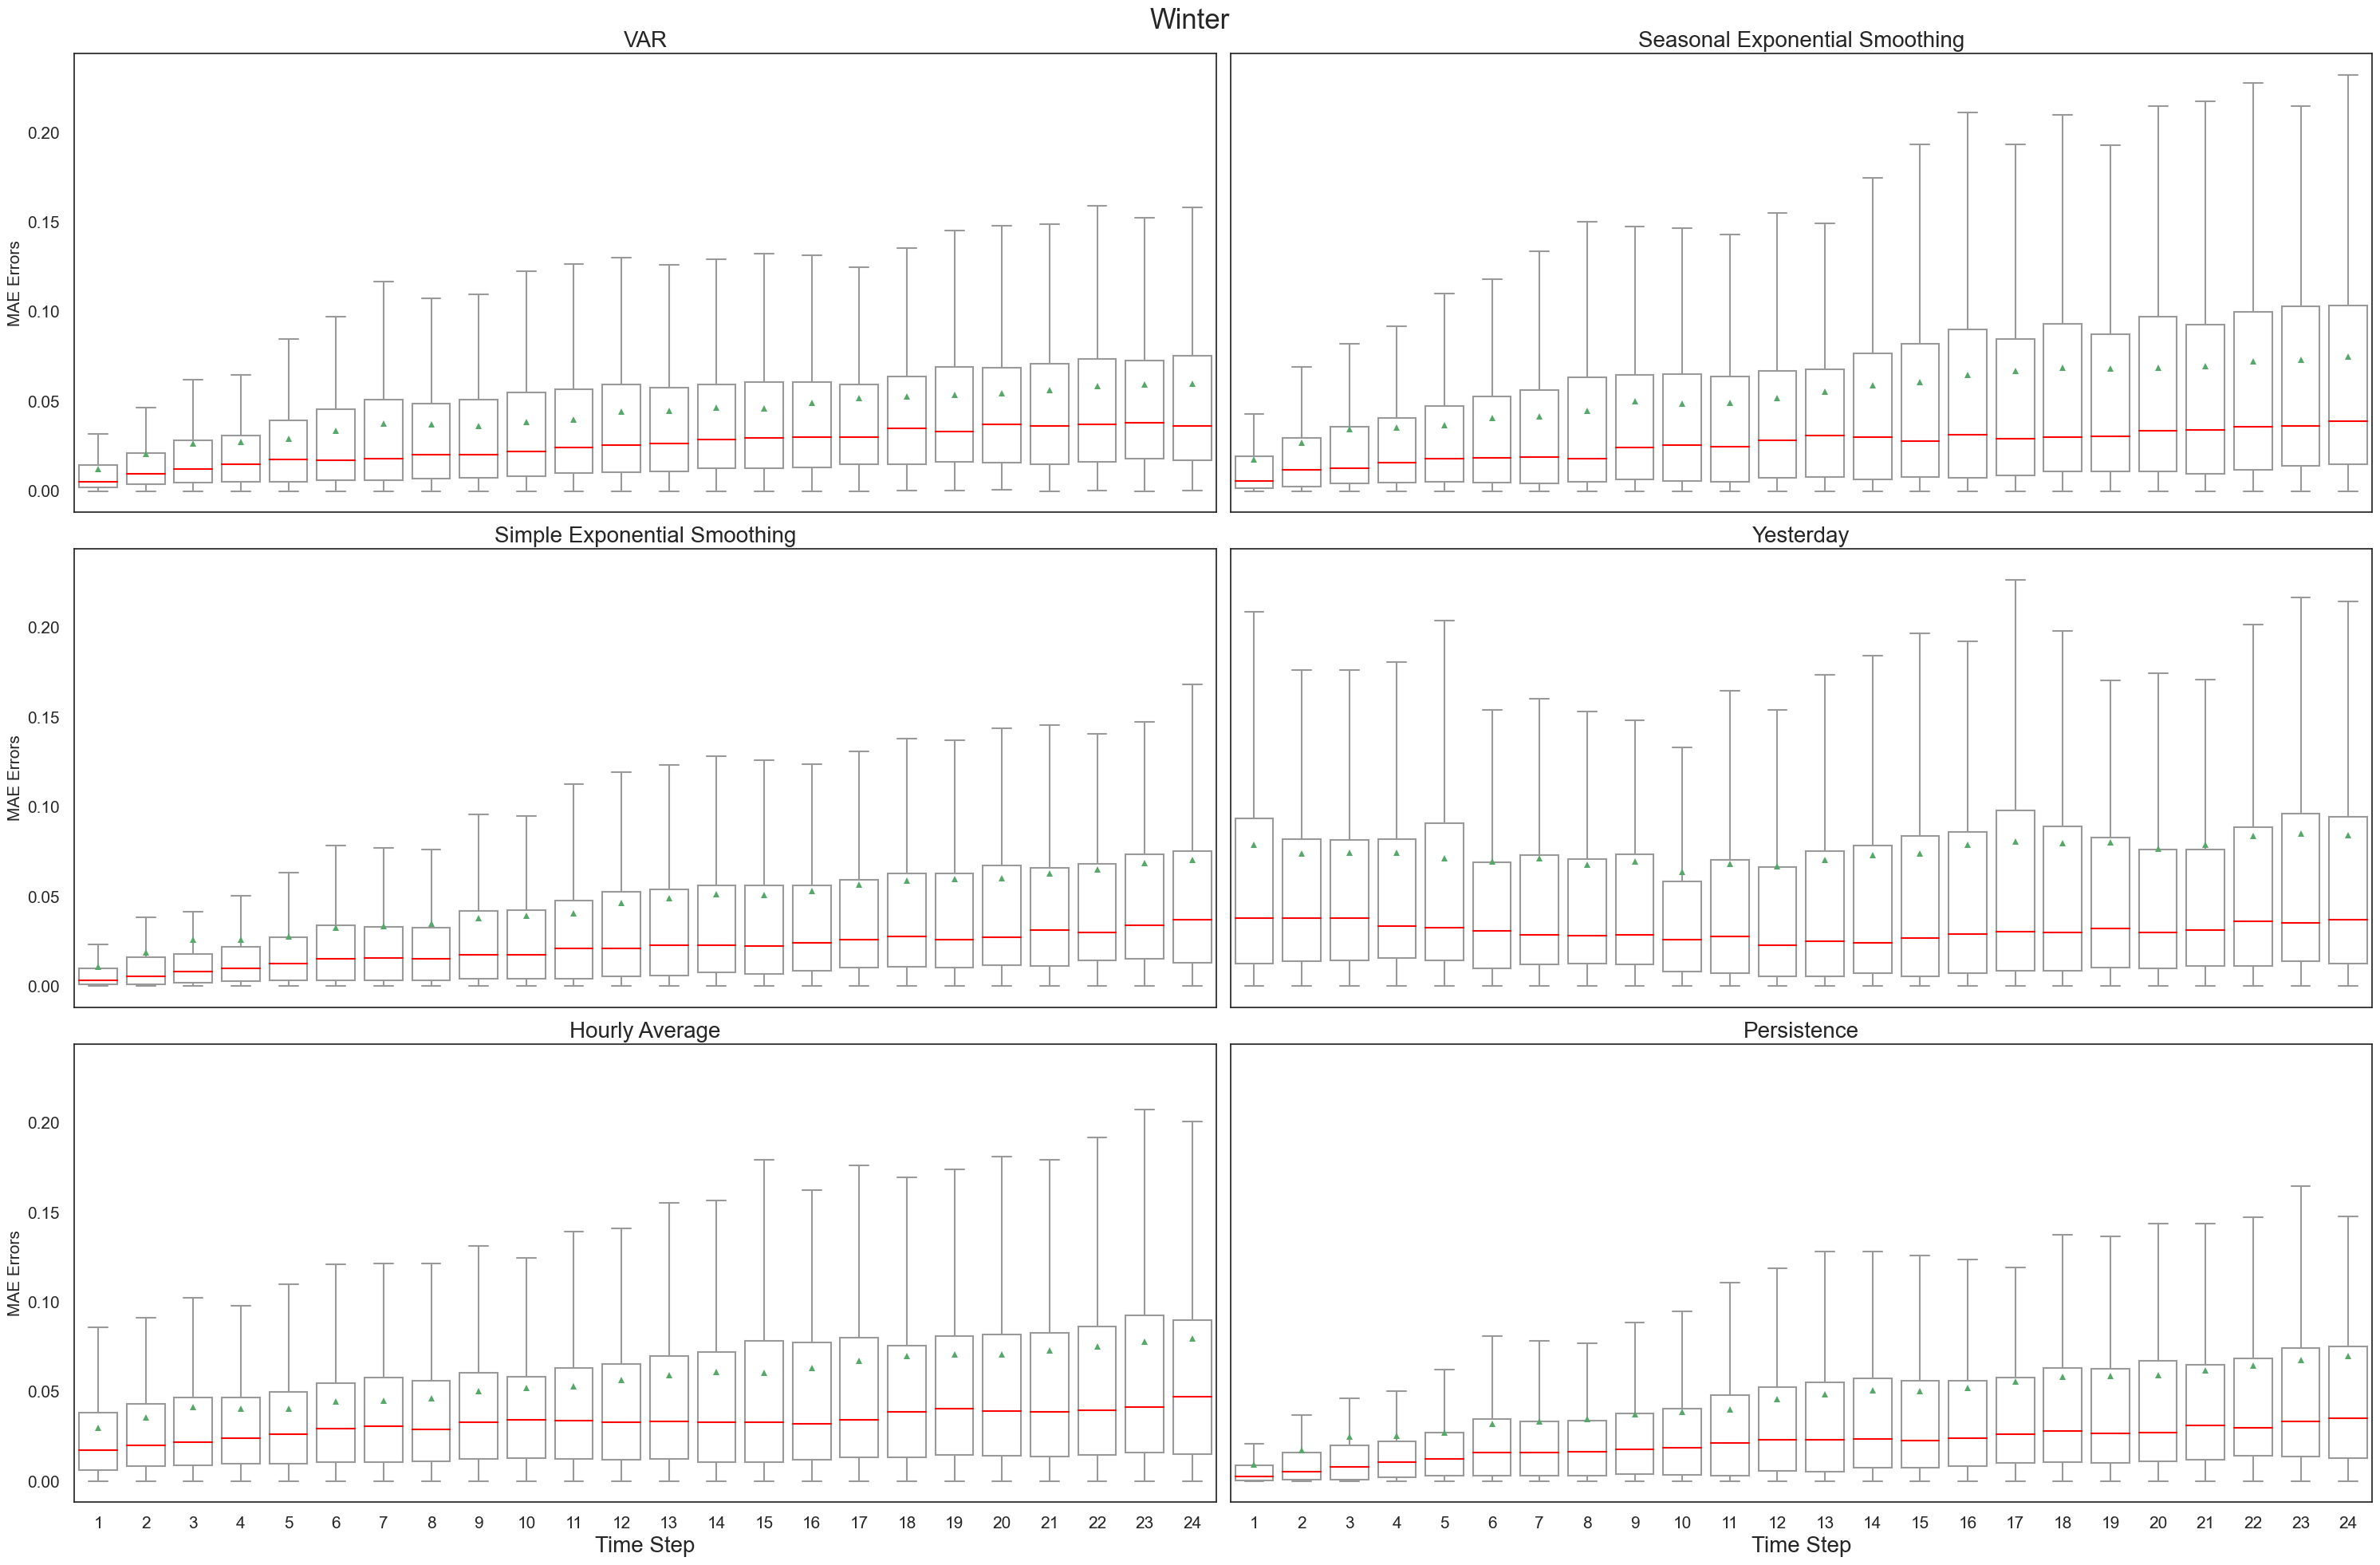

==> Loading data
==> Loaded data in: 0 m : 12 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec

skipping this iteration, min obs is violated for Exp smoothing


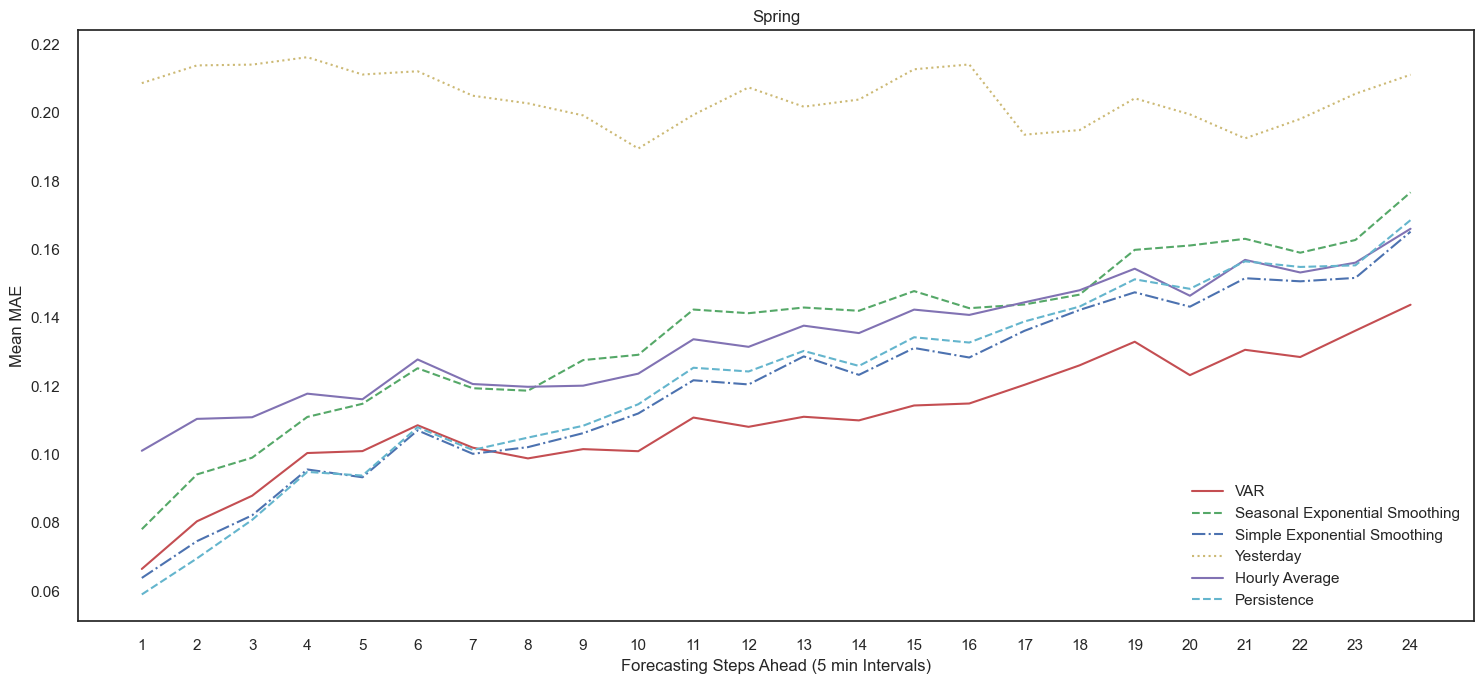

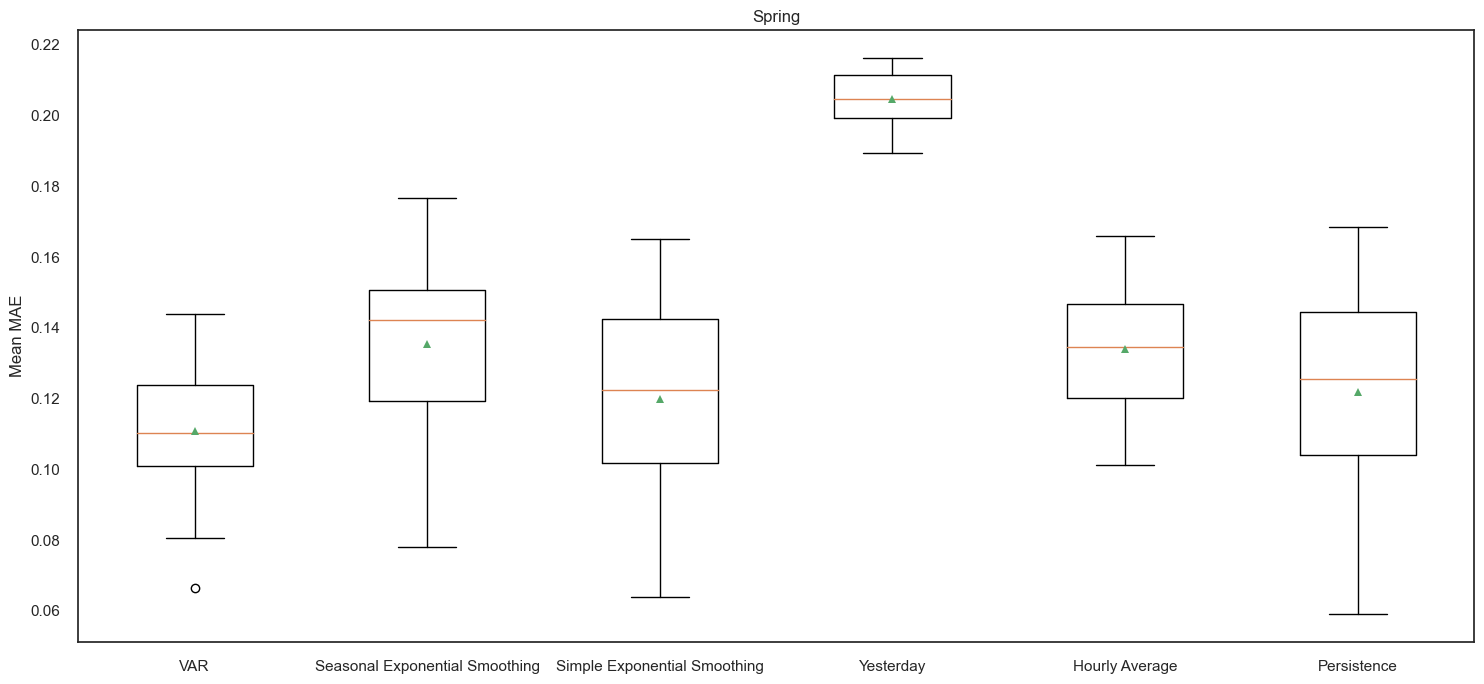

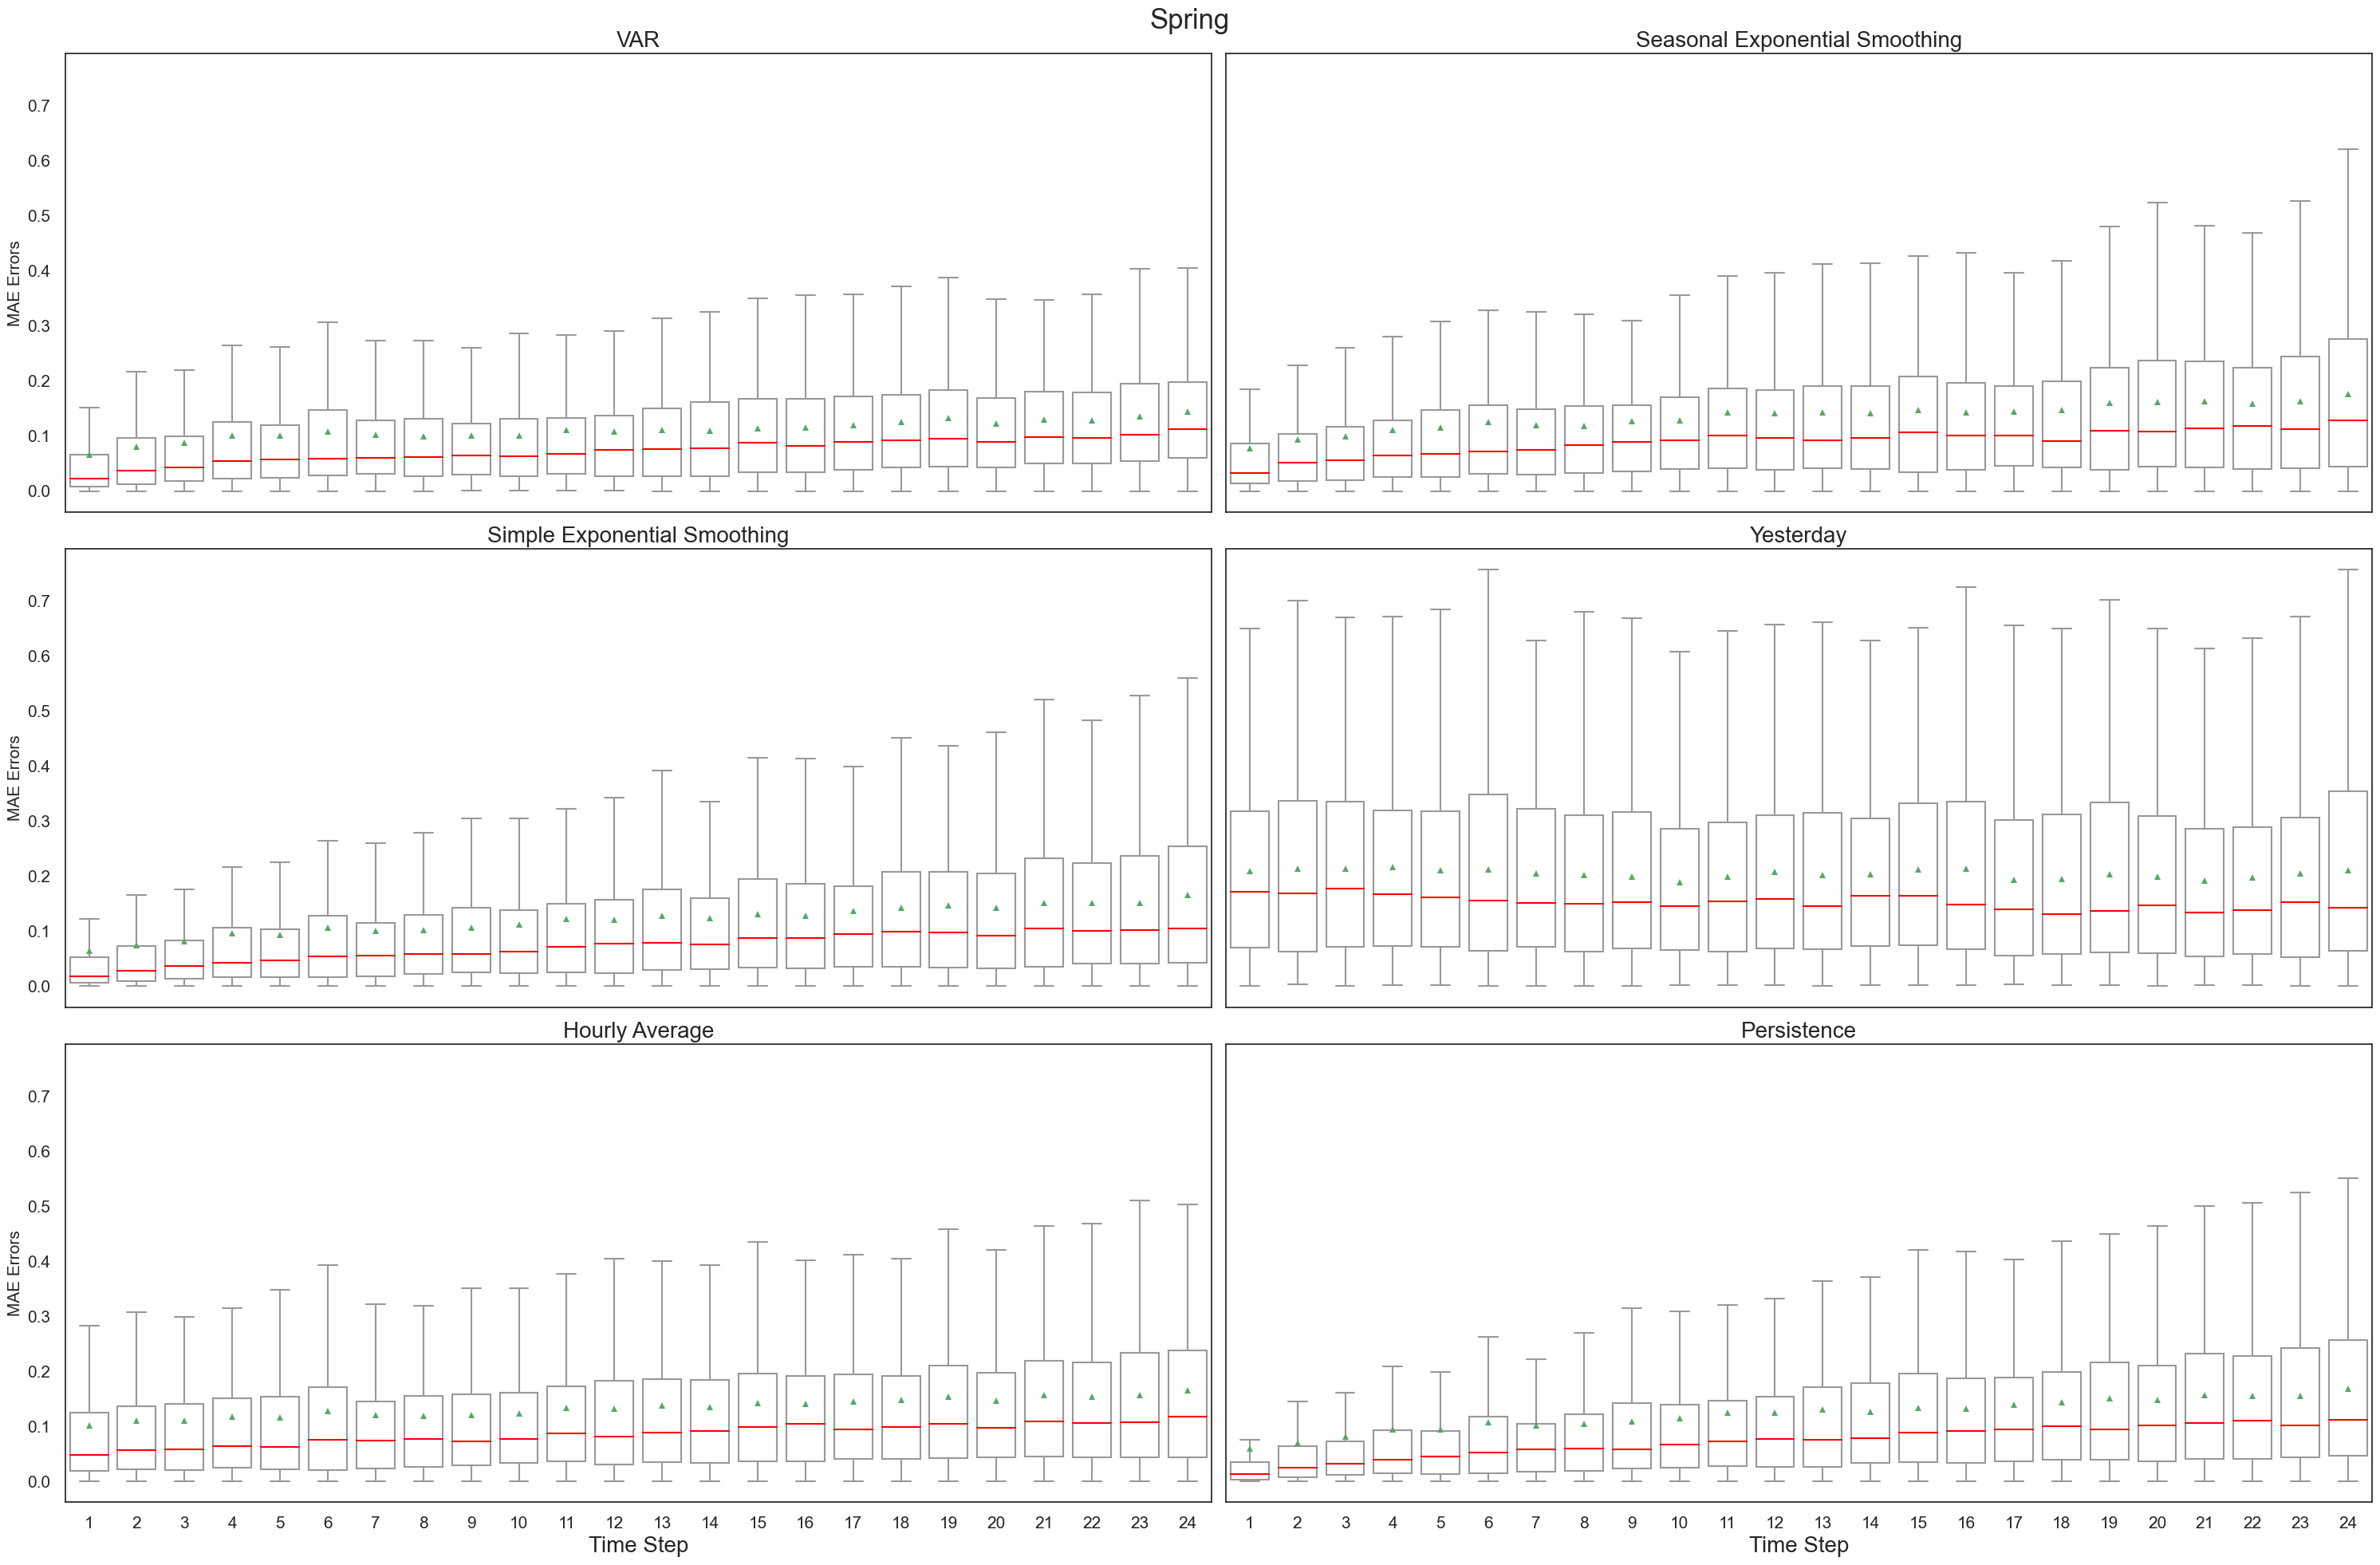

==> Loading data
==> Loaded data in: 0 m : 13 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



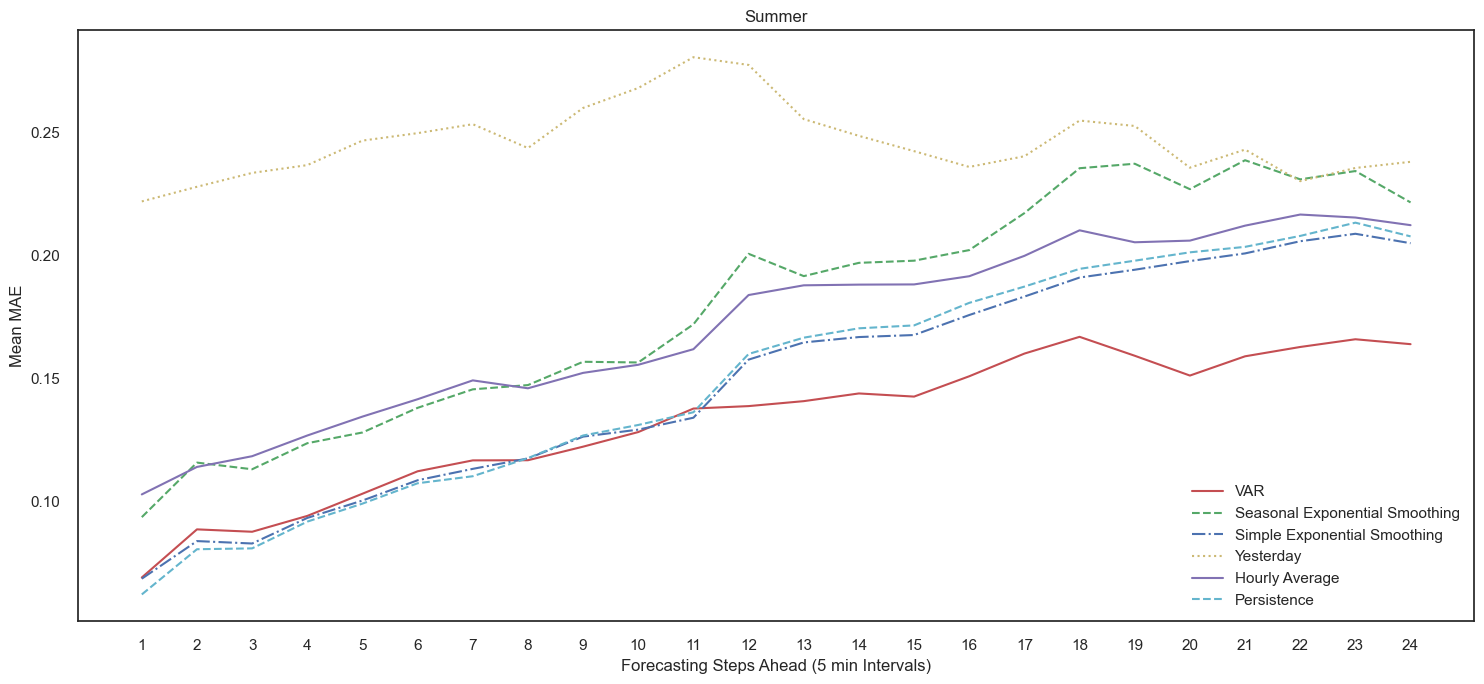

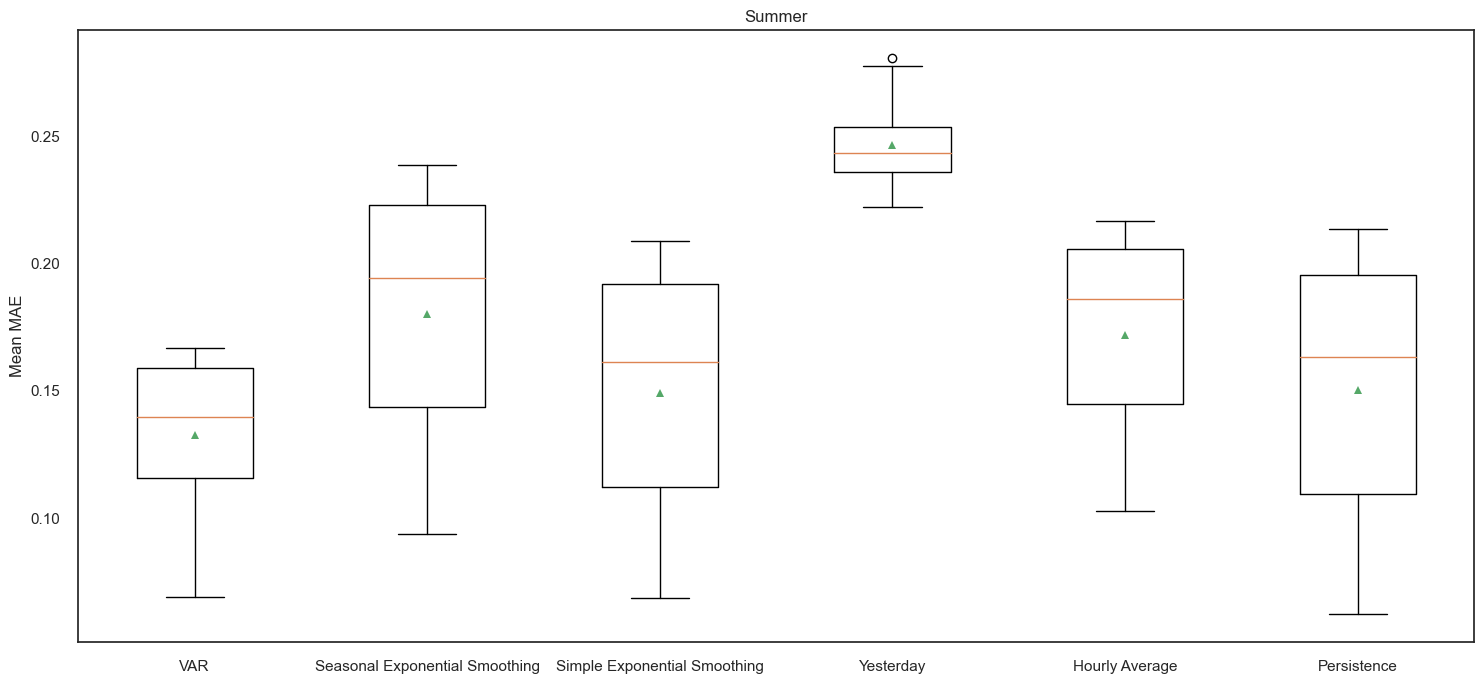

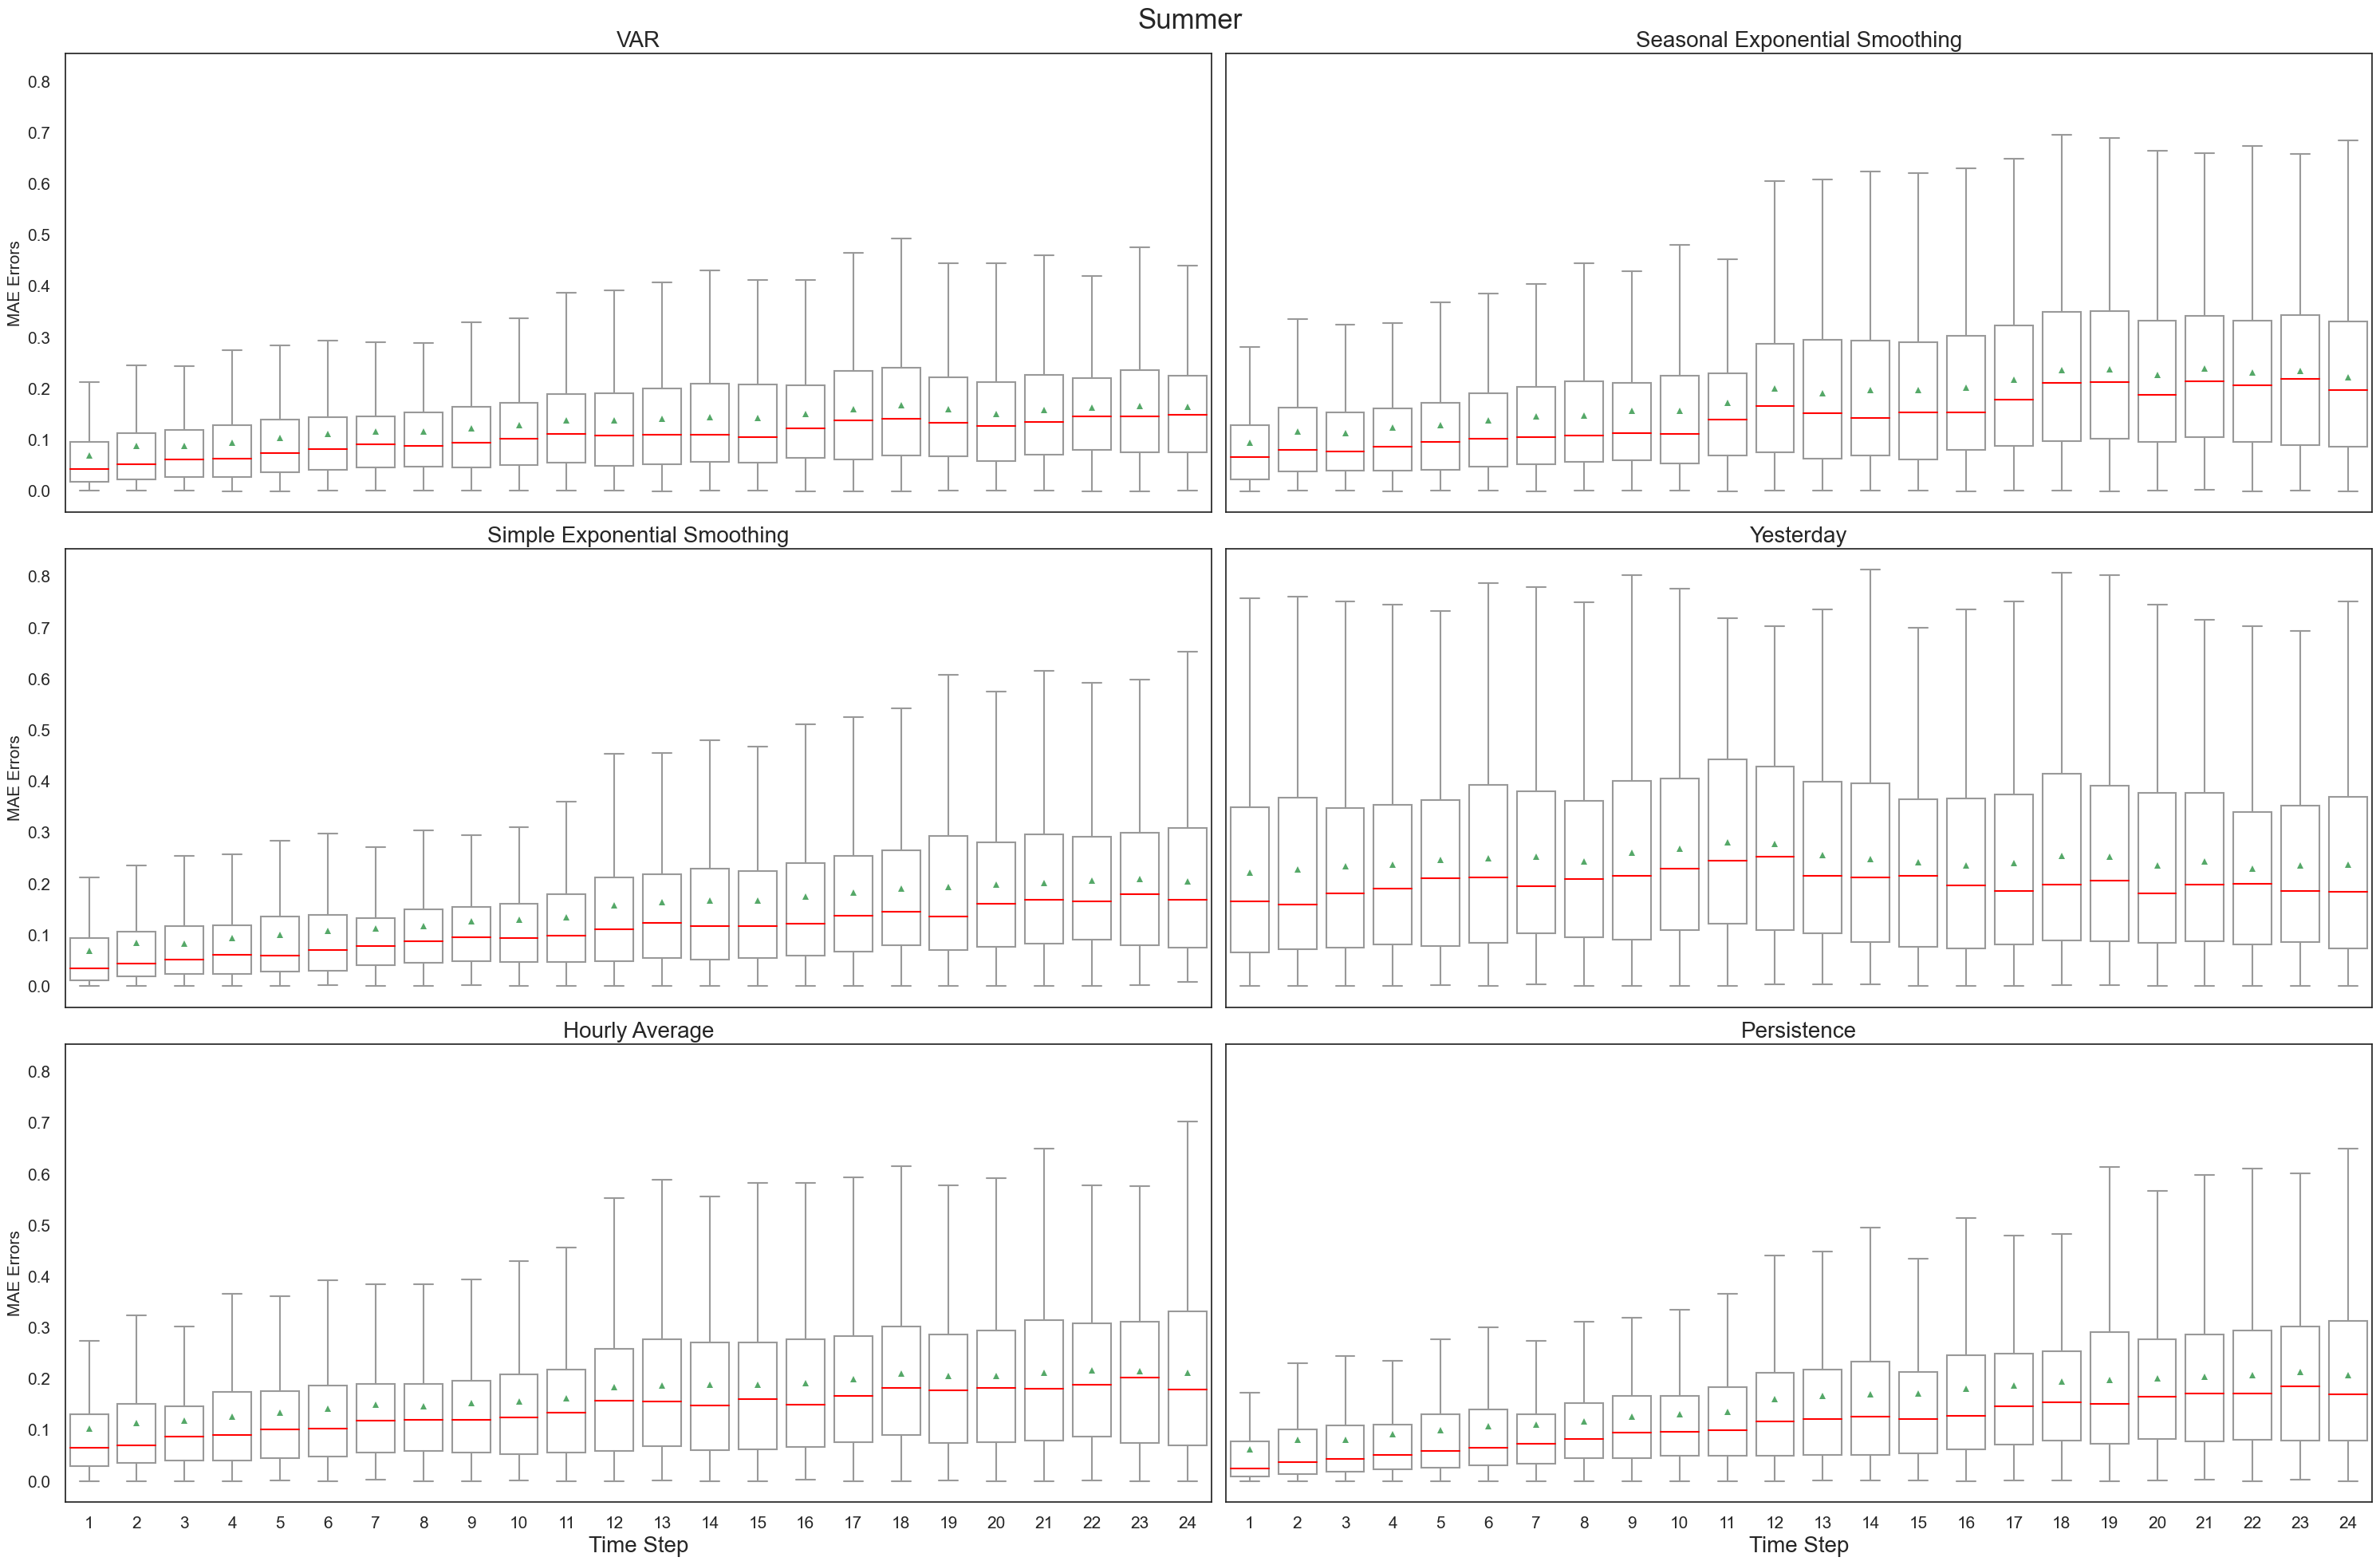

==> Loading data
==> Loaded data in: 0 m : 10 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec

skipping this iteration, min obs is violated for Exp smoothing
skipping this iteration, min obs is violated for Exp smoothing
skipping this iteration, min obs is violated for Exp smoothing
skipping this iteration, min obs is violated for Exp smoothing
skipping this iteration, min obs is violated for Exp smoothing
skipping this iteration, min obs is violated for Exp smoothing
skipping this iteration, min obs is violated for Exp smoothing
skipping this iteration, min obs is violated for Exp smoothing
skipping this iteration, min obs is violated for Exp smoothing


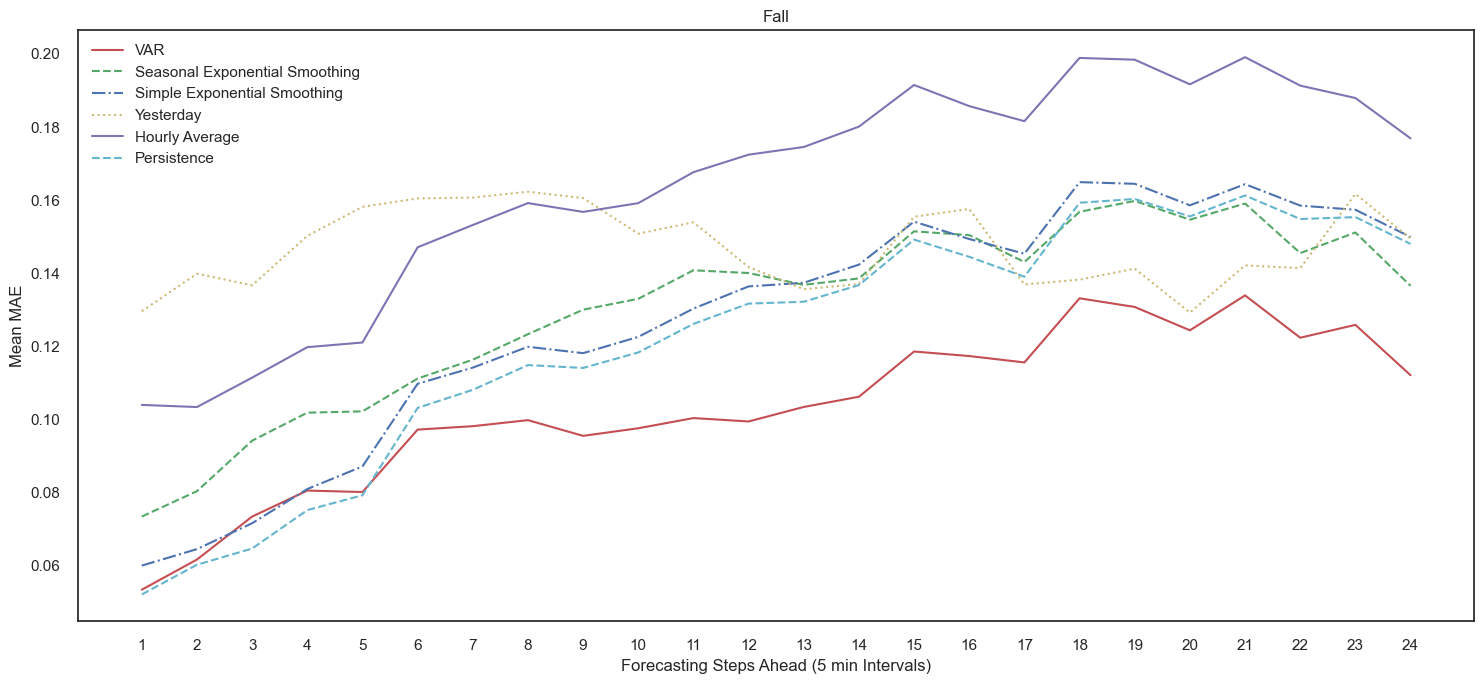

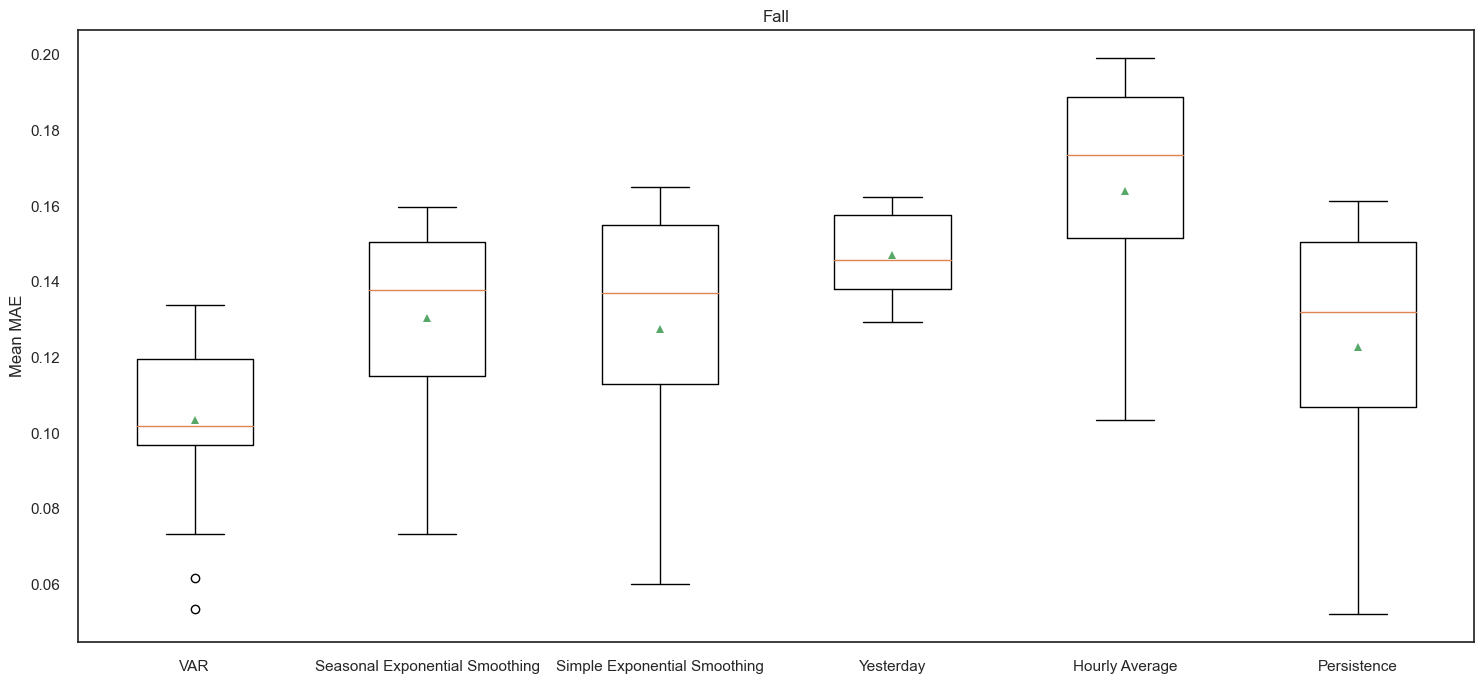

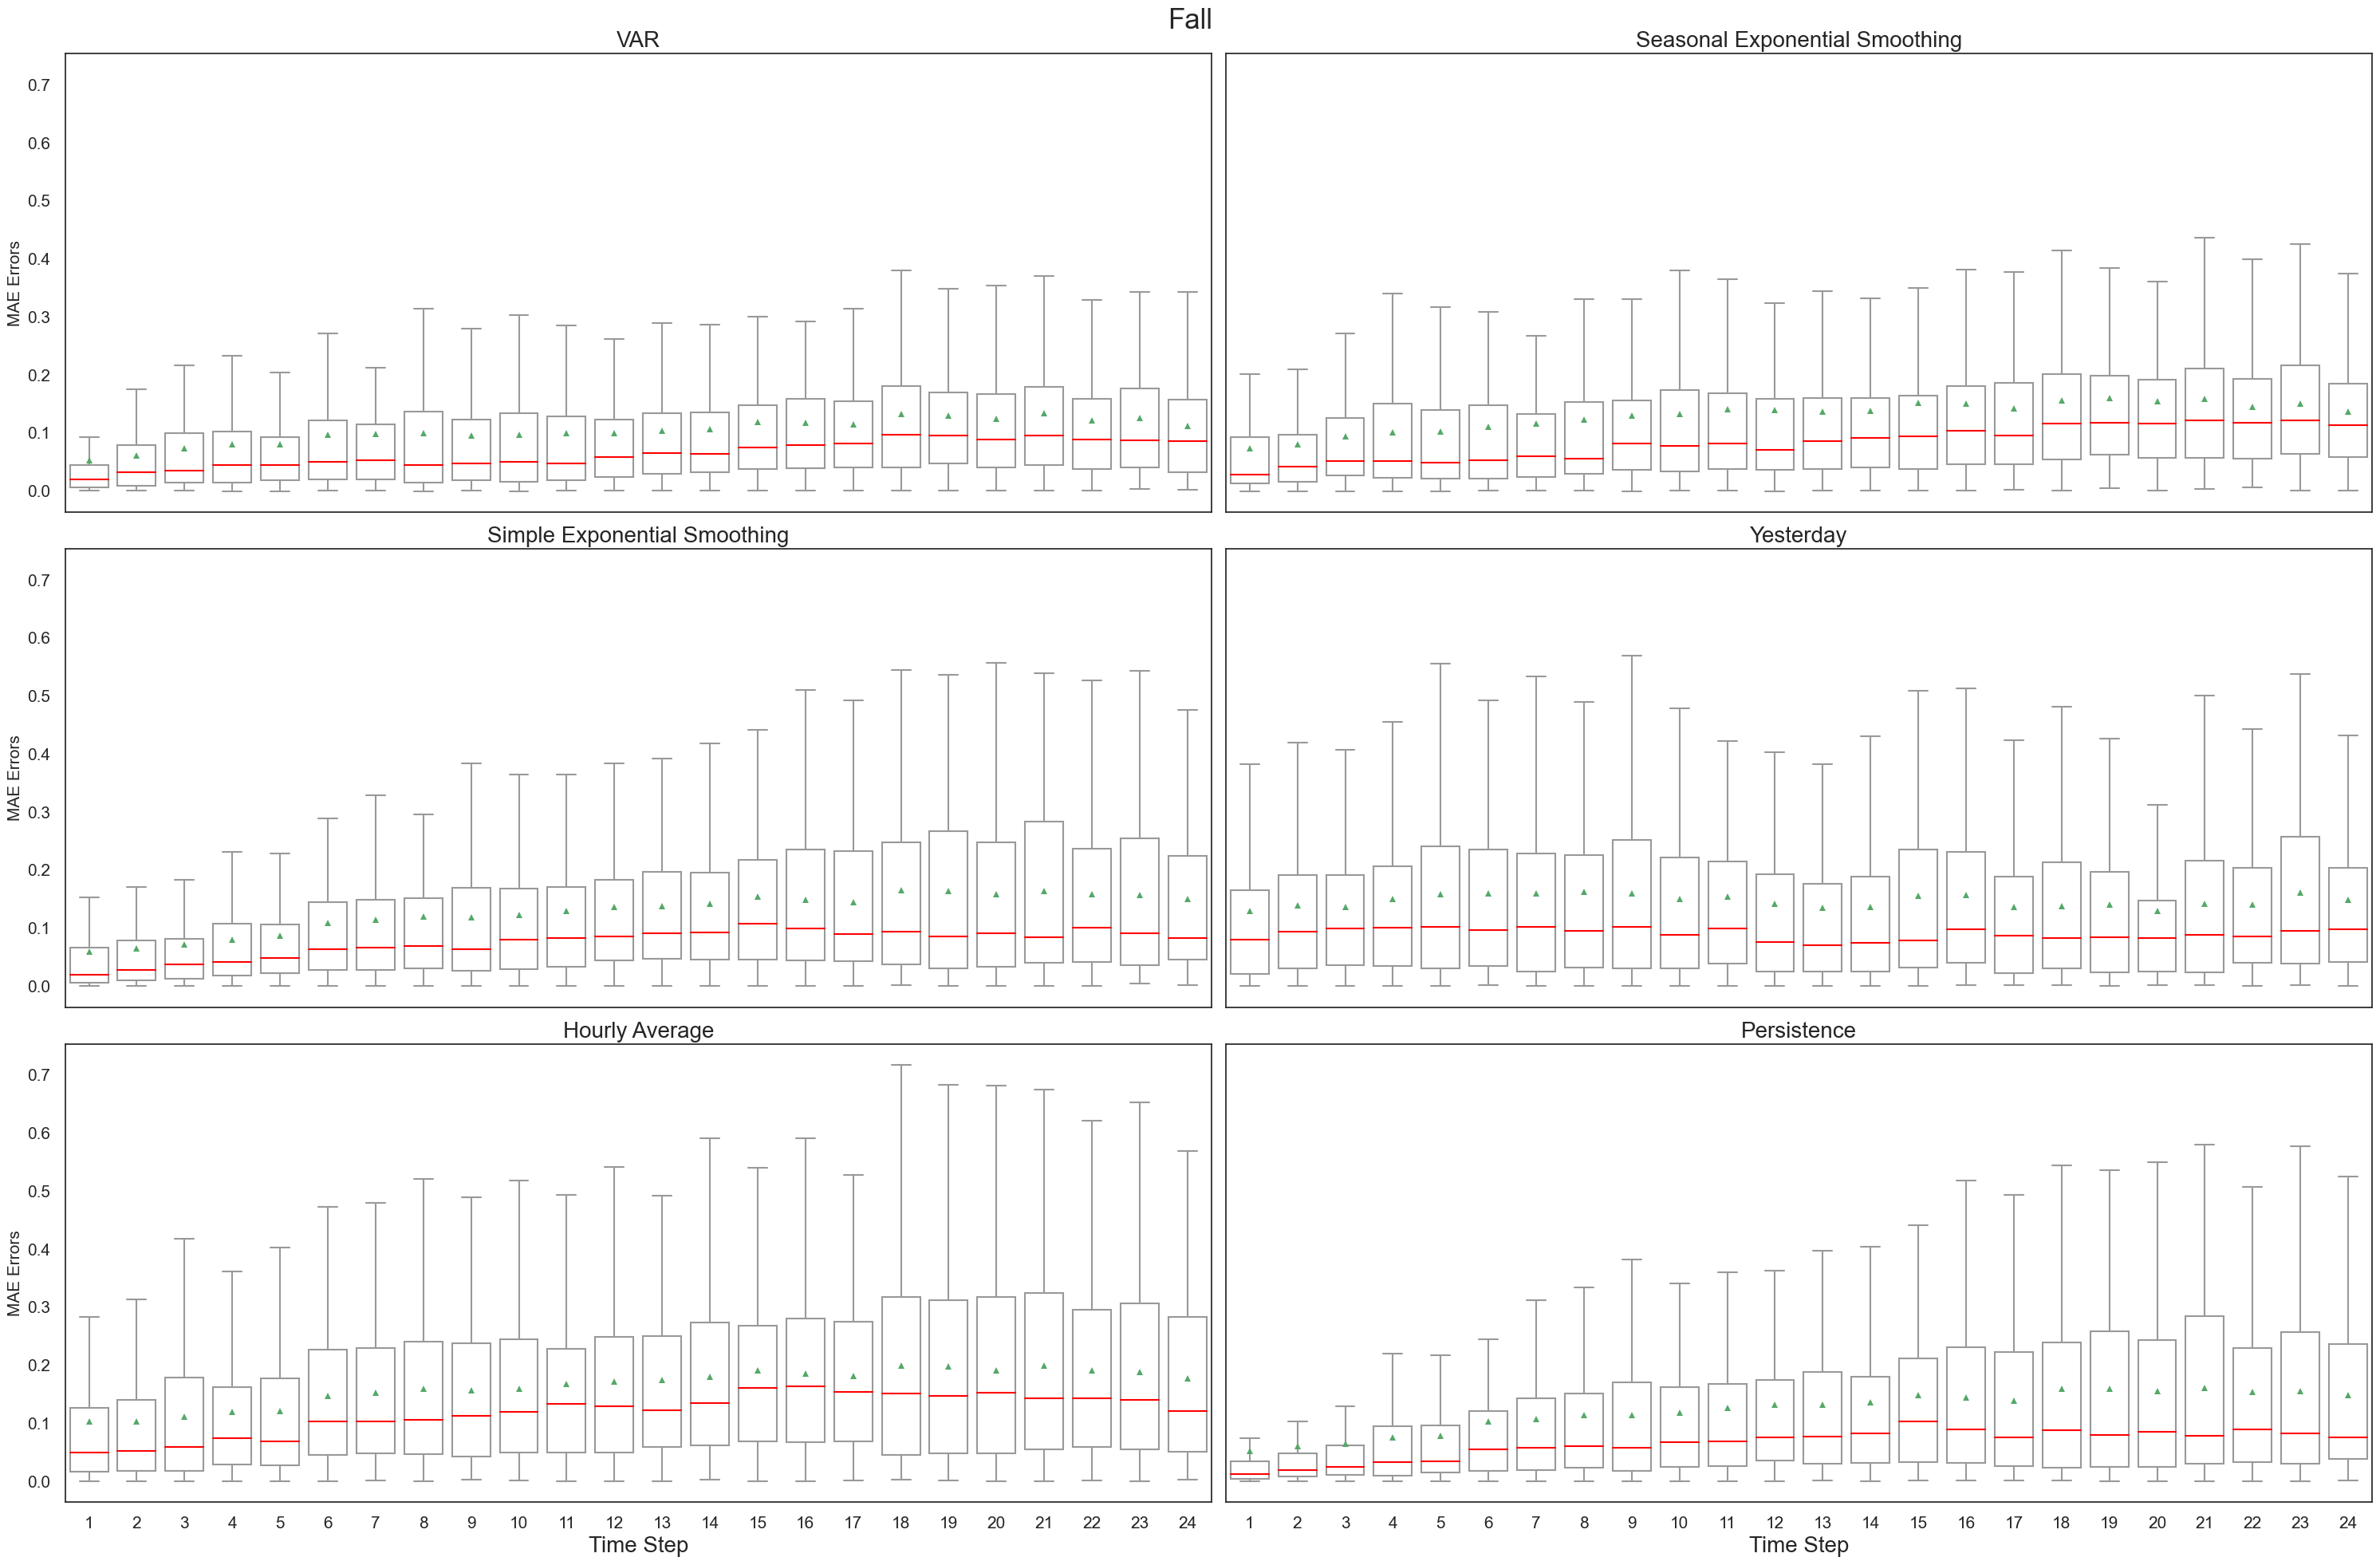

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))
import torch
import numpy as np
import pandas as pd
from models import (YesterdayForecast, 
                              HourlyAverage, 
                              Persistence, 
                              fit_var, 
                              fit_exp, 
                              fit_simple_exp,
                              var_exp_simulation)
from metrics import mean_absolute_error, get_mean_ci, nlpd_holt
from data import PVDataGenerator, PVDataLoader
from data.utils import cross_val_fold, train_test_split_fold, check_model_inputs
from pv_plot import plot_forecast_mae, boxplot_models, boxplot_forecast_horizon

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 90
N_DAYS_TRAIN = 5
MINUTE_INTERVAL = 5
DAILY_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
TOTAL_POINTS = int(N_DAYS * DAILY_POINTS)
INTERVAL = int(DAILY_POINTS * N_DAYS_TRAIN)
N_HOURS_PRED = 2
PRED_POINTS = N_HOURS_PRED * 60 // MINUTE_INTERVAL
N_SYSTEMS = 15
RADIUS = 0.35
CIRCLE_COORDS = (55, -1.5)
# create a tuple of 4 coordinates that form a polygon in the uk
models_list =['persistence', 'yesterday', 'hourly_avg', 'var', 'simple_exp', 'exp']
model_list = ['exp']

for season in ['winter', 'spring', 'summer', 'fall']:
    loader = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=CIRCLE_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='circle',
                    season=season,
                    drop_nan=False)

    X, y = loader.get_time_series()
    
    x_list, y_list = cross_val_fold(X, y, N_DAYS_TRAIN, DAILY_POINTS)
    x_train, y_train, x_test, y_test =  train_test_split_fold(x_list, y_list, N_HOURS_PRED, MINUTE_INTERVAL, DAY_MIN, DAY_MAX)

    train_loader = PVDataLoader(x_train, y_train)
    test_loader = PVDataLoader(x_test, y_test)

    var_j = 0
    exp_j = 0
    simple_exp_j = 0
    yesterday_j = 0
    hourly_avg_j = 0
    persist_j = 0
    gp_j = 0
    multitask_j = 0

    df_var = None
    df_exp = None
    df_simple_exp = None
    df_yesterday = None
    df_hourly_avg = None
    df_persistence = None
    df_gp = None
    df_multitask_gp = None
    df_multitask_gp_nlpl = None

    psd_error = False


    for (x_train, y_train), (x_test, y_test) in zip(train_loader, test_loader):
        # check for constant columns in y_train
        
        x_train, y_train, x_test, y_test = check_model_inputs(x_train, y_train, x_test, y_test)
        # returns none if too many values are nan or constant
        if x_train is None:
            continue


        for model in models_list:
            if model not in ['gp', 'multitask_gp', 'holt'] and isinstance(y_train, torch.Tensor):
                y_train = y_train.numpy()
                y_test = y_test.numpy()
            
            elif model in ['gp', 'multitask_gp', 'holt'] and not isinstance(y_train, torch.Tensor):
                y_train = torch.from_numpy(y_train)
                y_test = torch.from_numpy(y_test)

            if model == 'var':
                
                y_pred = fit_var(y_train, PRED_POINTS)
                mae = mean_absolute_error(y_test, y_pred)
                for k in range(mae.shape[-1]):
                    if df_var is None:
                        df_var = pd.DataFrame({f'var_mae{var_j}': mae[:,k]})
                    else:
                        new_df = pd.DataFrame({f'var_mae{var_j}': mae[:,k]})
                        df_var = pd.concat([df_var, new_df], axis=1)
                    var_j += 1
            
            elif model == 'exp':
                
                for k in range(y_train.shape[-1]): 
                    y_pred, fitted_model = fit_exp(y_train[:,k], PRED_POINTS)
                    var = var_exp_simulation(fitted_model, y_pred, n_pred=PRED_POINTS)
                   
                    if np.isnan(y_pred).any():
                        continue
                    mae = mean_absolute_error(y_test[:,k], y_pred)
                    nlpd = nlpd_holt(y_pred, var, y_test[:,k])

                    if df_exp is None:
                        df_exp = pd.DataFrame({f'exp_mae{exp_j}': mae})
                    else:
                        new_df = pd.DataFrame({f'exp_mae{exp_j}': mae})
                        df_exp = pd.concat([df_exp, new_df], axis=1)
                    
            
            elif model == 'simple_exp':
                for k in range(y_train.shape[-1]): 
                    y_pred, fitted_model = fit_simple_exp(y_train[:,k], PRED_POINTS)
                    var = var_exp_simulation(fitted_model, y_pred, n_pred=PRED_POINTS)
                   
                    if np.isnan(y_pred).any():
                        continue
                    mae = mean_absolute_error(y_test[:,k], y_pred)
                    nlpd = nlpd_holt(y_pred, var, y_test[:,k])
                
                    if df_simple_exp is None:
                        df_simple_exp = pd.DataFrame({f'simple_exp_mae{simple_exp_j}': mae})
                    else:
                        new_df = pd.DataFrame({f'simple_exp_mae{simple_exp_j}': mae})
                        df_simple_exp = pd.concat([df_simple_exp, new_df], axis=1)
                    simple_exp_j += 1
            
            elif model == 'yesterday':
                model = YesterdayForecast(DAY_MIN, DAY_MAX, MINUTE_INTERVAL)
                y_pred = model.predict(y_train)
                mae = mean_absolute_error(y_test, y_pred)
                
                for k in range(mae.shape[-1]):
                    if df_yesterday is None:
                        df_yesterday = pd.DataFrame({f'yesterday_mae{yesterday_j}': mae[:,k]})
                    else:
                        new_df = pd.DataFrame({f'yesterday_mae{yesterday_j}': mae[:,k]})
                        df_yesterday = pd.concat([df_yesterday, new_df], axis=1)
                
                    yesterday_j += 1
            
            elif model == 'hourly_avg':
                
                model = HourlyAverage(DAY_MIN, DAY_MAX, MINUTE_INTERVAL)
                y_pred = model.predict(y_train)
                
                mae = mean_absolute_error(y_test, y_pred)
                for k in range(mae.shape[-1]):
                    if df_hourly_avg is None:
                        df_hourly_avg = pd.DataFrame({f'hourly_avg_mae{hourly_avg_j}': mae[:,k]})
                    else:
                        new_df = pd.DataFrame({f'hourly_avg_mae{hourly_avg_j}': mae[:,k]})
                        df_hourly_avg = pd.concat([df_hourly_avg, new_df], axis=1)
                    hourly_avg_j += 1
            
            elif model == 'persistence':
                model = Persistence()
                y_pred = model.predict(y_train, PRED_POINTS)
                mae = mean_absolute_error(y_test, y_pred)
                for k in range(mae.shape[-1]):
                    if df_persistence is None:
                        df_persistence = pd.DataFrame({f'persistence_mae{persist_j}': mae[:,k]})
                    else:
                        new_df = pd.DataFrame({f'persistence_mae{persist_j}': mae[:,k]})
                        df_persistence = pd.concat([df_persistence, new_df], axis=1)
                    persist_j += 1
          

    # dictionary of data frames
    df_dict = {'VAR': df_var, 
            'Seasonal Exponential Smoothing': df_exp, 
            'Simple Exponential Smoothing': df_simple_exp, 
            'Yesterday': df_yesterday, 
            'Hourly Average': df_hourly_avg, 
            'Persistence': df_persistence,
        
            }

    mean_var, lower_var, upper_var = get_mean_ci(df_var)
    mean_exp, lower_exp, upper_exp = get_mean_ci(df_exp)
    mean_simple_exp, lower_simple_exp, upper_simple_exp = get_mean_ci(df_simple_exp)
    mean_yesterday, lower_yesterday, upper_yesterday = get_mean_ci(df_yesterday)
    mean_hourly_avg, lower_hourly_avg, upper_hourly_avg = get_mean_ci(df_hourly_avg)
    mean_persistence, lower_persistence, upper_persistence = get_mean_ci(df_persistence)

    results = {'VAR': {'mean': mean_var, 'lower': lower_var, 'upper': upper_var},
    'Seasonal Exponential Smoothing': {'mean': mean_exp, 'lower': lower_exp, 'upper': upper_exp},
    'Simple Exponential Smoothing': {'mean': mean_simple_exp, 'lower': lower_simple_exp, 'upper': upper_simple_exp},
    'Yesterday': {'mean': mean_yesterday, 'lower': lower_yesterday, 'upper': upper_yesterday},
    'Hourly Average': {'mean': mean_hourly_avg, 'lower': lower_hourly_avg, 'upper': upper_hourly_avg},
    'Persistence': {'mean': mean_persistence, 'lower': lower_persistence, 'upper': upper_persistence},
    }

    plot_forecast_mae(results, season)
    boxplot_models(results, season)
    boxplot_forecast_horizon(df_dict, season=season)
